In [ ]:
#pip install pandas numpy matplotlib seaborn statsmodels pmdarima


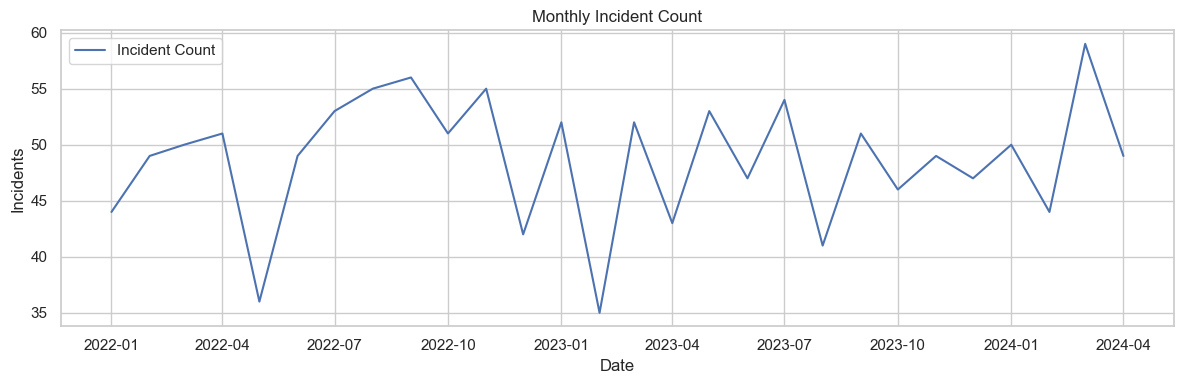

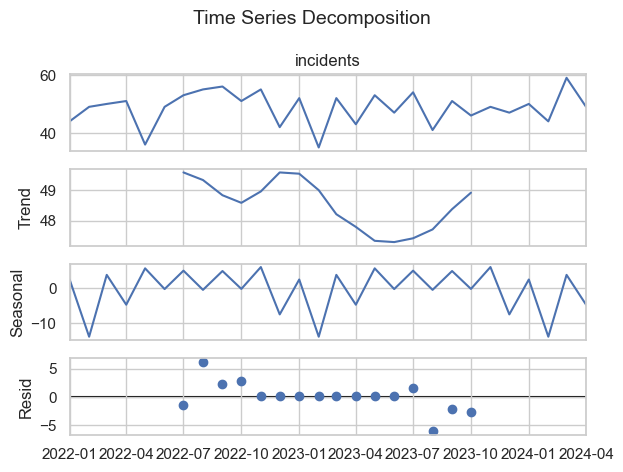

ADF Statistic: -2.5427
p-value: 0.1054


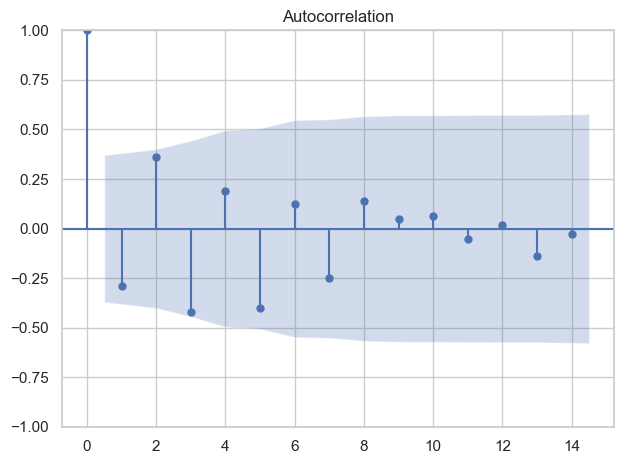

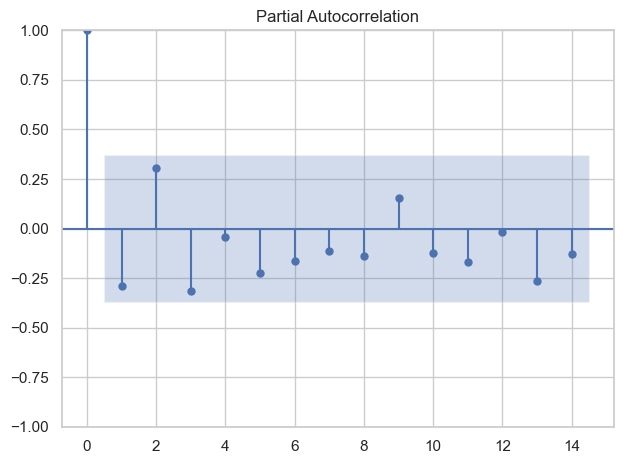

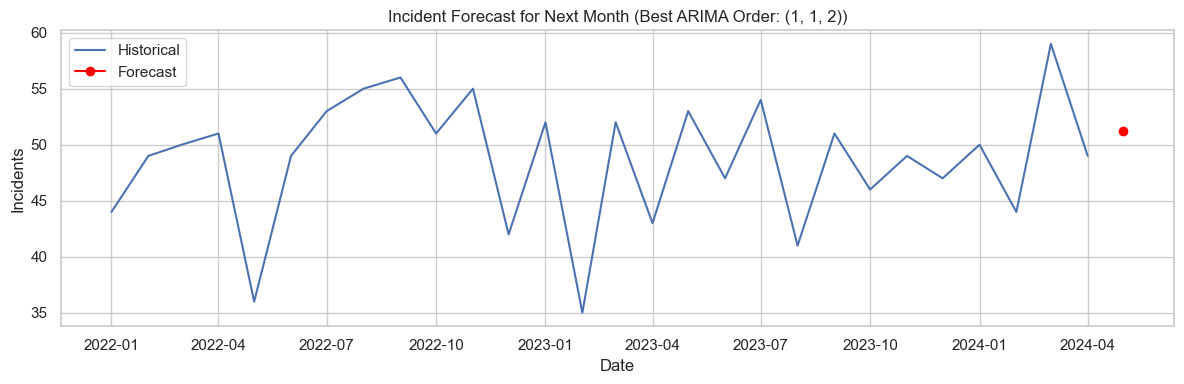

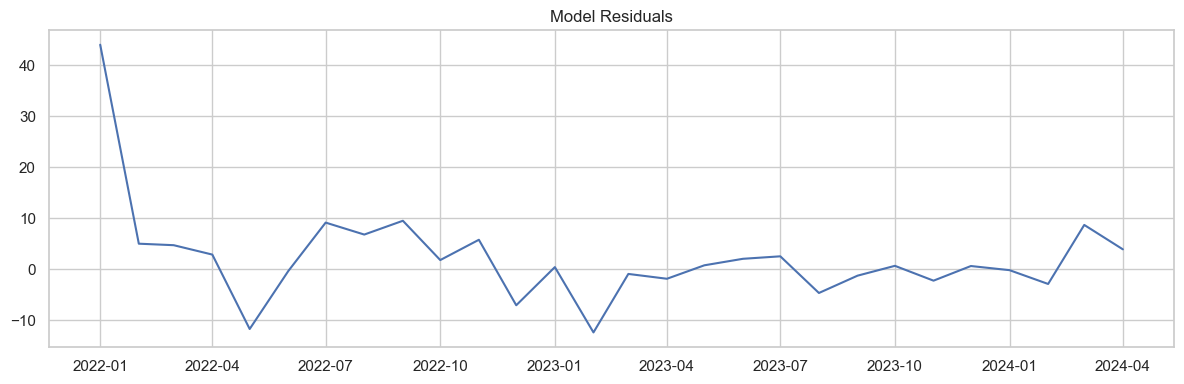

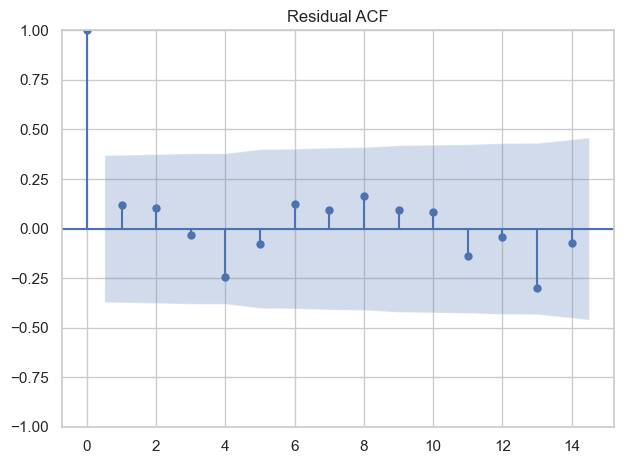

Backtest MAE: 4.14
Backtest RMSE: 4.14
Best ARIMA order: (1, 1, 2)
Forecasted incidents for May 2024: 51


In [17]:
# arima_forecast_incidents.py (auto-tuned ARIMA)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style="whitegrid")

# Simulated sample data (replace with your actual CSV)
date_rng = pd.date_range(start='2022-01-01', end='2024-04-01', freq='MS')
data = np.random.poisson(lam=50, size=len(date_rng))
df = pd.DataFrame({'date': date_rng, 'incidents': data})

# Ensure datetime index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')

# Plot the series
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['incidents'], label='Incident Count')
plt.title('Monthly Incident Count')
plt.xlabel('Date')
plt.ylabel('Incidents')
plt.legend()
plt.tight_layout()
plt.show()

# Time series decomposition
result = seasonal_decompose(df['incidents'], model='additive')
result.plot()
plt.suptitle('Time Series Decomposition', fontsize=14)
plt.tight_layout()
plt.show()

# ADF Test for stationarity
adf_result = adfuller(df['incidents'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

# ACF and PACF plots
plot_acf(df['incidents'])
plt.tight_layout()
plt.show()

plot_pacf(df['incidents'])
plt.tight_layout()
plt.show()

# Find best (p,d,q) by minimizing AIC
import warnings
from itertools import product
warnings.filterwarnings("ignore")

p = d = q = range(0, 3)
pdq_combinations = list(product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq_combinations:
    try:
        model = ARIMA(df['incidents'], order=order)
        fitted = model.fit()
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_order = order
            best_model = fitted
    except:
        continue

# Forecast next 1 month using best model
forecast = best_model.forecast(steps=1)
forecast_date = df.index[-1] + pd.DateOffset(months=1)

# Forecast DataFrame
forecast_df = pd.DataFrame({
    'date': [forecast_date],
    'forecast': forecast
}).set_index('date')

# Plot historical + forecast
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['incidents'], label='Historical')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', marker='o', color='red')
plt.title(f'Incident Forecast for Next Month (Best ARIMA Order: {best_order})')
plt.xlabel('Date')
plt.ylabel('Incidents')
plt.legend()
plt.tight_layout()
plt.show()

# Residual diagnostics
residuals = best_model.resid
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Model Residuals')
plt.tight_layout()
plt.show()

plot_acf(residuals)
plt.title('Residual ACF')
plt.tight_layout()
plt.show()

# Simple backtest: train on all but last point, forecast last point
train = df.iloc[:-1]
test = df.iloc[-1:]
test_model = ARIMA(train, order=best_order).fit()
test_forecast = test_model.forecast(steps=1)

mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))
print(f"Backtest MAE: {mae:.2f}")
print(f"Backtest RMSE: {rmse:.2f}")

# Final result
print(f"Best ARIMA order: {best_order}")
print(f"Forecasted incidents for {forecast_date.strftime('%B %Y')}: {int(forecast[0])}")

In [ ]:
# arima_forecast_incidents.py (auto-tuned ARIMA wrapped in class)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
import warnings

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

class ARIMABenchmark:
    def __init__(self, df: pd.DataFrame, date_col: str, value_col: str):
        self.df = df.copy()
        self.date_col = date_col
        self.value_col = value_col
        self.best_order = None
        self.best_model = None
        self.forecast_df = None

    def preprocess(self):
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])
        self.df.set_index(self.date_col, inplace=True)
        self.df = self.df.asfreq('MS')

    def visualize_series(self):
        plt.figure(figsize=(12, 4))
        plt.plot(self.df.index, self.df[self.value_col], label='Incident Count')
        plt.title('Monthly Incident Count')
        plt.xlabel('Date')
        plt.ylabel('Incidents')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def decompose_series(self):
        result = seasonal_decompose(self.df[self.value_col], model='additive')
        result.plot()
        plt.suptitle('Time Series Decomposition', fontsize=14)
        plt.tight_layout()
        plt.show()

    def stationarity_test(self):
        adf_result = adfuller(self.df[self.value_col])
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")

    def show_acf_pacf(self):
        plot_acf(self.df[self.value_col])
        plt.tight_layout()
        plt.show()

        plot_pacf(self.df[self.value_col])
        plt.tight_layout()
        plt.show()

    def fit_arima(self):
        p = d = q = range(0, 3)
        pdq_combinations = list(product(p, d, q))
        best_aic = np.inf
        for order in pdq_combinations:
            try:
                model = ARIMA(self.df[self.value_col], order=order)
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    self.best_order = order
                    self.best_model = fitted
            except:
                continue

    def forecast_next(self):
        forecast = self.best_model.forecast(steps=1)
        forecast_date = self.df.index[-1] + pd.DateOffset(months=1)
        self.forecast_df = pd.DataFrame({'date': [forecast_date], 'forecast': forecast}).set_index('date')

        plt.figure(figsize=(12, 4))
        plt.plot(self.df.index, self.df[self.value_col], label='Historical')
        plt.plot(self.forecast_df.index, self.forecast_df['forecast'], label='Forecast', marker='o', color='red')
        plt.title(f'Incident Forecast (ARIMA Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Incidents')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"Best ARIMA order: {self.best_order}")
        print(f"Forecasted incidents for {forecast_date.strftime('%B %Y')}: {int(forecast[0])}")

    def residual_diagnostics(self):
        residuals = self.best_model.resid
        plt.figure(figsize=(12, 4))
        plt.plot(residuals)
        plt.title('Model Residuals')
        plt.tight_layout()
        plt.show()

        plot_acf(residuals)
        plt.title('Residual ACF')
        plt.tight_layout()
        plt.show()

    def backtest(self):
        train = self.df.iloc[:-1]
        test = self.df.iloc[-1:]
        model = ARIMA(train[self.value_col], order=self.best_order).fit()
        forecast = model.forecast(steps=1)
        mae = mean_absolute_error(test[self.value_col], forecast)
        rmse = np.sqrt(mean_squared_error(test[self.value_col], forecast))
        print(f"Backtest MAE: {mae:.2f}")
        print(f"Backtest RMSE: {rmse:.2f}")


# ============================
# Example Usage
# ============================
if __name__ == "__main__":
    date_rng = pd.date_range(start='2022-01-01', end='2024-04-01', freq='MS')
    data = np.random.poisson(lam=50, size=len(date_rng))
    df = pd.DataFrame({'date': date_rng, 'incidents': data})

    arima = ARIMABenchmark(df, date_col='date', value_col='incidents')
    arima.preprocess()
    arima.visualize_series()
    arima.decompose_series()
    arima.stationarity_test()
    arima.show_acf_pacf()
    arima.fit_arima()
    arima.forecast_next()
    arima.residual_diagnostics()
    arima.backtest()
